In [79]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

## Feature selection 
Enitre workflow with all models for the target variables relative content loss and business reduction (degree of loss) as well for the binary version of relative content loss (chance of loss)

Due to the samll sample size a nested CV is used to have the possibility to even get generalization error, in the inner CV the best hyperaparamters based on k-fold are selected; in the outer cv the generalization error across all tested models is evaluated. A seprate unseen validation set as done by train-test split would have an insufficent small sample size.
Nested CV is computationally intensive but with the samll sample size and a well chosen set of only most important hyperparameters this can be overcome.

- Logistic Regression (binary rcloss)
- Elastic Net
- eXtreme Gradient Boosting
- Conditional Random Forest


In [80]:
import sys
import numpy as np
import pandas as pd

import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_error

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

sys.path.insert(0, "../../")
import utils.feature_selection as fs
import utils.training as t
import utils.evaluation as e
import utils.evaluation_metrics as em
import utils.figures as f
import utils.settings as s
import utils.pipelines as p
import utils.preprocessing as pp

p.main()  # create/update model settings
#s.init()
seed = s.seed

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))

import contextlib
import warnings
warnings.filterwarnings('ignore')


targets = ["Target_relative_contentloss_euro", "Target_businessreduction"]
target = targets[1]


<Figure size 2000x1000 with 0 Axes>

#### Load R packages to process Conditional Random Forest in python
*Note 1: all needed R packages have to be previously loaded in R*

*Note 2: Make sure that caret package version >= 6.0-81, otherwise caret.train() throws an error*

In [81]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr, data
import rpy2.robjects.packages as rpackages


# get basic R packages
utils = importr('utils')
base = importr('base')
dplyr = importr('dplyr')
stats_r = importr("stats")  # rename due to similar python package

# pandas.DataFrames to R dataframes 
from rpy2.robjects import pandas2ri, Formula
pandas2ri.activate()

# print r df in html
import rpy2.ipython.html
rpy2.ipython.html.init_printing()


# get libraries for CRF processing, ctree_controls etc
#partykit = importr('partykit') # for single Conditional Inference tree
party = importr('party')        # Random Forest with Conditional Inference Trees (Conditional Random Forest)
permimp = importr('permimp')  # conditional permutation feature importance
caret = importr('caret') # package version needs to be higher than  >=  6.0-90
nestedcv = importr('nestedcv')
tdr = importr("tdr")


In [82]:
#df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_tueb.xlsx")
df_candidates = pd.read_excel("../../input_survey_data/input_data_businessreduction_tueb.xlsx")


print(df_candidates.shape)
df_candidates.tail(2)

(393, 17)


,Target_businessreduction,inundation_duration_h,water_depth_cm,flowvelocity,flood_experience,bage,b_area,shp_employees,shp_avgmonthly_sale,hh_monthly_income,emergency_measures,precautionary_measures_lowcost,precautionary_measures_expensive,resilience,resilienceLeftAlone,contaminations,shp_content_value_euro
391,NaN,4.0,70.0,0.1,76,NaN,130.0,2,20.0,NaN,0.333333,0.50,0.333333,1.0,5.0,1,NaN
392,0.0,3.0,100.0,0.1,36,5.0,33.0,2,20.0,0.0,0.333333,0.25,0.000000,0.0,2.5,1,NaN


In [83]:
df_candidates = df_candidates.drop("shp_avgmonthly_sale", axis=1)


In [84]:

print(df_candidates.shape)
df_candidates.tail(2)


(393, 16)


,Target_businessreduction,inundation_duration_h,water_depth_cm,flowvelocity,flood_experience,bage,b_area,shp_employees,hh_monthly_income,emergency_measures,precautionary_measures_lowcost,precautionary_measures_expensive,resilience,resilienceLeftAlone,contaminations,shp_content_value_euro
391,NaN,4.0,70.0,0.1,76,NaN,130.0,2,NaN,0.333333,0.50,0.333333,1.0,5.0,1,NaN
392,0.0,3.0,100.0,0.1,36,5.0,33.0,2,0.0,0.333333,0.25,0.000000,0.0,2.5,1,NaN


In [85]:
## delete features with more than 10% missing values
#print("Percentage of missing values per feature [%]\n", round(df_candidates.isna().mean().sort_values(ascending=False)[:15]  * 100), 2) 
df_candidates.isna().mean()

Target_businessreduction            0.091603
inundation_duration_h               0.022901
water_depth_cm                      0.002545
flowvelocity                        0.000000
flood_experience                    0.000000
bage                                0.068702
b_area                              0.005089
shp_employees                       0.000000
hh_monthly_income                   0.055980
emergency_measures                  0.000000
precautionary_measures_lowcost      0.000000
precautionary_measures_expensive    0.000000
resilience                          0.000000
resilienceLeftAlone                 0.000000
contaminations                      0.000000
shp_content_value_euro              0.157761
dtype: float64

In [86]:
## keep reislience and perception indicator
# df_candidates = df_candidates.loc[:,df_candidates.filter(regex="^(?!resilience_*)").columns]
# df_candidates = df_candidates.loc[:,df_candidates.filter(regex="^(?!perception_*)").columns]


### Correlations between candidate predictors and targets

In [87]:
# from scipy import stats

# def corrdot(*args, **kwargs):
#     corr_r = args[0].corr(args[1], method="spearman", min_periods=100)
#     #corr_r = args[0].corr(args[1], 'pearson')
#     corr_text = round(corr_r, 2)
#     ax = plt.gca()
#     font_size = abs(corr_r) * 80 + 5
#     ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
#                 ha='center', va='center', fontsize=font_size)

# def corrfunc(x, y, **kws):
#     r, p = stats.pearsonr(x, y)
#     p_stars = ''
#     if p <= 0.05:
#         p_stars = '*'
#     if p <= 0.01:
#         p_stars = '**'
#     if p <= 0.001:
#         p_stars = '***'
#     ax = plt.gca()
#     ax.annotate(p_stars, xy=(0.65, 0.6), xycoords=ax.transAxes,
#                 color='red', fontsize=70)



In [88]:
# df = df_candidates
# df = df.dropna()

# sns.set(style='white', font_scale=1.6)

# g = sns.PairGrid(df, aspect=1.5, diag_sharey=False, despine=False)
# g.map_lower(sns.regplot, lowess=True, ci=False,
#             line_kws={'color': 'red', 'lw': 1},
#             scatter_kws={'color': 'black', 's': 20})
# g.map_diag(sns.distplot, color='black',
#            kde_kws={'color': 'red', 'cut': 0.7, 'lw': 1},
#            hist_kws={'histtype': 'bar', 'lw': 2,
#                      'edgecolor': 'k', 'facecolor':'grey'})
# g.map_diag(sns.rugplot, color='black')
# g.map_upper(corrdot)
# g.map_upper(corrfunc)
# g.fig.subplots_adjust(wspace=0, hspace=0)

# # Remove axis labels
# for ax in g.axes.flatten():
#     ax.set_ylabel('')
#     ax.set_xlabel('')

# # Add titles to the diagonal axes/subplots
# for ax, col in zip(np.diag(g.axes), df.columns):
#     ax.set_title(col, y=0.82, fontsize=26)

## Fit model 

In [89]:
score_metrics = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(em.mean_bias_error, greater_is_better=False),
    "MBE": make_scorer(em.mean_bias_error, greater_is_better=False),
    "R2": "r2",
    "SMAPE": make_scorer(em.symmetric_mean_absolute_percentage_error, greater_is_better=False)
}


In [1]:

#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

# ## Feature selection 
# Enitre workflow with all models for the target variables relative content loss and business reduction (degree of loss) as well for the binary version of relative content loss (chance of loss)
# 
# Due to the samll sample size a nested CV is used to have the possibility to even get generalization error, in the inner CV the best hyperaparamters based on k-fold are selected; in the outer cv the generalization error across all tested models is evaluated. A seprate unseen validation set as done by train-test split would have an insufficent small sample size.
# Nested CV is computationally intensive but with the samll sample size and a well chosen set of only most important hyperparameters this can be overcome.
# 
# - Logistic Regression (binary rcloss)
# - Elastic Net
# - eXtreme Gradient Boosting
# - Random Forest
# 

import sys
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, "../../")
import utils.feature_selection as fs
import utils.training as t
import utils.evaluation as e
import utils.evaluation_metrics as em
import utils.figures as f
import utils.settings as s
import utils.pipelines as p
import utils.preprocessing as pp

p.main()  # create/update model settings
#s.init()
seed = s.seed

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))

import contextlib
import warnings
warnings.filterwarnings('ignore')

#### Load R packages to process Conditional Random Forest in python
# *Note 1: all needed R packages have to be previously loaded in R*
# *Note 2: Make sure that caret package version >= 6.0-81, otherwise caret.train() throws an error*
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr, data
import rpy2.robjects.packages as rpackages

# get basic R packages
utils = importr('utils')
base = importr('base')
dplyr = importr('dplyr')
stats_r = importr("stats")  # rename due to similar python package

# pandas.DataFrames to R dataframes 
from rpy2.robjects import pandas2ri, Formula
pandas2ri.activate()

# print r df in html
#import rpy2.ipython.html
#rpy2.ipython.html.init_printing()

# get libraries for CRF processing, ctree_controls etc
#partykit = importr('partykit') # for single Conditional Inference tree
party = importr('party')        # Random Forest with Conditional Inference Trees (Conditional Random Forest)
permimp = importr('permimp')  # conditional permutation feature importance
caret = importr('caret') # package version needs to be higher than  >=  6.0-90
nestedcv = importr('nestedcv')
tdr = importr("tdr")


targets = ["Target_relative_contentloss_euro", "Target_businessreduction"]
target = targets[1]

## settings for cv
kfolds_and_repeats = 2, 2  # <k-folds, repeats> for nested cv
cv = RepeatedKFold(n_splits=kfolds_and_repeats[0], n_repeats=kfolds_and_repeats[1], random_state=seed)

## save models and their evaluation in following folders:
Path(f"../models_trained/nested_cv_models").mkdir(parents=True, exist_ok=True)
Path(f"../models_trained/final_models").mkdir(parents=True, exist_ok=True)
Path(f"../models_evaluation/commercial").mkdir(parents=True, exist_ok=True)
Path(f"../selected_features/commercial").mkdir(parents=True, exist_ok=True)


#df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_tueb.xlsx")
df_candidates = pd.read_excel("../../input_survey_data/input_data_businessreduction_tueb.xlsx")


print(df_candidates.shape)
df_candidates.tail(2)

## Fit model 
score_metrics = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(em.root_mean_squared_error, greater_is_better=False),
    "MBE": make_scorer(em.mean_bias_error, greater_is_better=False),
    "R2": "r2",
    "SMAPE": make_scorer(em.symmetric_mean_absolute_percentage_error, greater_is_better=False)
}



## empty variables to store model outputs
eval_sets = {}
models_trained = {}
final_models_trained = {}
models_coef = {}
predicted_values = {}
df_feature_importances = pd.DataFrame(index=df_candidates.drop(target, axis=1).columns.to_list())
models_scores = {}

## iterate over piplines. Each pipline contains a scaler and regressor (and optionally a bagging method) 
pipelines = ["pipe_crf", "pipe_en", "pipe_xgb"]  

## Load set of hyperparamters
hyperparams_set = pp.load_config("../../utils/hyperparameter_sets.json")


for pipe_name in pipelines:

    model_name = pipe_name.split('_')[1]
    print( f"\nApplying {model_name} on {target}")

    df_Xy = df_candidates
    X_names = df_Xy.drop(target, axis=1).columns.to_list()

    ## remove zero-loss records only for combined dataset
    if target == "Target_relative_contentloss_euro":
        print(f"Removing {df_Xy.loc[df_Xy[target]==0.0,:].shape[0]} zero loss records")
        df_Xy = df_Xy.loc[df_Xy[target]!=0.0,:]
        print(f"Keeping {df_Xy.shape} damage cases for model training and evaluation")


    ## drop samples where target is nan
    print(f"Dropping {df_Xy[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
    df_Xy = df_Xy[ ~df_Xy[f"{target}"].isna()]

    ## Elastic Net and Random Forest: drop samples where any value is nan
    if (model_name == "en") | (model_name == "crf"):
        df_Xy.dropna(inplace=True)

    print(
        "Using ",
        df_Xy.shape[0],
        " records, from those are ",
        {(df_Xy[target][df_Xy[target] == 0.0]).count()},
        " cases with zero-loss or zero-reduction",
    )

    X = df_Xy[X_names]
    y = df_Xy[target]

    ## load model pipelines and hyperparameter space
    pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')
    param_space = hyperparams_set[f"{model_name}_hyperparameters"]

    ## if bagging is used
    if "bag" in pipe_name.split("_"):
        print(f"Testing {model_name} with bagging")
        param_space = { k.replace('model', 'bagging__estimator') : v for (k, v) in param_space.items()}


    if model_name != "crf":

        ## fit model for unbiased model evaluation and for final model used for Feature importance, Partial Dependence etc.
        mf = t.ModelFitting(
            model=pipe, 
            Xy=df_Xy,
            target_name=target,
            param_space=hyperparams_set[f"{model_name}_hyperparameters"],
            tuning_score="neg_mean_absolute_error",
            cv=cv,
            kfolds_and_repeats=kfolds_and_repeats,
            seed=seed,
        )
        models_trained_ncv = mf.model_fit_ncv()

        # save models from nested cv and final model on entire ds
        joblib.dump(models_trained_ncv, f"../models_trained/nested_cv_models/{model_name}_{target}.joblib")
            
        ## evaluate model    
        me = e.ModelEvaluation(
            models_trained_ncv=models_trained_ncv, 
            Xy=df_Xy,
            target_name=target,
            score_metrics=score_metrics,
            cv=cv,
            kfolds=kfolds_and_repeats[0],
            seed=seed,
        )
        model_evaluation_results = me.model_evaluate_ncv()

        
        ## visual check if hyperparameter ranges are good or need to be adapted
        for i in range(len(model_evaluation_results["estimator"])):
            print(f"{model_name}: ", model_evaluation_results["estimator"][i].best_params_)


        ## store models evaluation 
        models_scores[model_name] =  {
            k: model_evaluation_results[k] for k in tuple("test_" + s for s in list(score_metrics.keys()))
        } # get evaluation scores, metric names start with "test_<metricname>"


        ## Final model

        ## get final model based on best MAE score during outer cv
        best_idx = list(models_scores[model_name]["test_MAE"]).index(max(models_scores[model_name]["test_MAE"]))
        final_model = model_evaluation_results["estimator"][best_idx]
        print("used params for best model:", final_model.best_params_)  # use last model as the best one
        final_model = final_model.best_estimator_

        ## predict on entire dataset and save final model
        y_pred = final_model.predict(X) 
        final_models_trained[model_name] = final_model 
        joblib.dump(final_model, f"../models_trained/final_models/{model_name}_{target}.joblib")


        ## Feature importance of best model
        importances = me.permutation_feature_importance(final_model, repeats=5)


        ## regression coefficients for linear models
        with contextlib.suppress(Exception): 
            # models_coef[model_name] = me.calc_regression_coefficients(final_model)
            # outfile = f"../models_evaluation/regression_coefficients_{model_name}_{target}.xlsx"
            # models_coef[model_name].round(3).to_excel(outfile, index=True)
            # print("Regression Coefficients:\n", models_coef[model_name].sort_values("probabilities", ascending=False), f"\n.. saved to {outfile}")

            ## try to get coefficients of final predictor
            # models_coef[model_name] = me.calc_regression_coefficients(final_model, sanity_test=True)
            import statsmodels.api as sm
            from scipy import stats
            from sklearn.linear_model import LinearRegression

            def calc_standard_error(y, y_pred, newX):  # TODO move them outside class or to utils.py
                MSE = (sum((y - y_pred)**2))/(len(newX)-len(newX[0]))
                ## MSE = (sum((y-y_pred)**2))/(len(newX)-len(X.columns))
                var_b = MSE*(np.linalg.inv(np.dot(newX.T, newX)).diagonal())
                return np.sqrt(var_b)
            def calc_p_values(ts_b, newX):
                p_values =  [2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]
                return p_values

            ## make sanity check
            sanity_test = True
            if sanity_test:
                X_exog = MinMaxScaler().fit_transform(X)#, 
                # y = self.y

                ## reference: p-values from statsmodels
                m = sm.OLS(y, sm.add_constant(X_exog))
                m_res = m.fit()
                #print(m_res.summary())
                p_values_reference = m_res.summary2().tables[1]['P>|t|']

                ## self calculated p-values
                reg = LinearRegression().fit(X_exog, y)
                y_pred_test = reg.predict(X_exog)
                coefs_intercept = np.append(reg.intercept_, list(reg.coef_))

                ## calc p-values
                newX = np.append(np.ones((len(X_exog),1)), X_exog, axis=1)
                sd_b = calc_standard_error(y, y_pred_test, newX)  # standard error calculated based on MSE of newX
                ts_b = coefs_intercept / sd_b        # t values
                p_values = calc_p_values(ts_b, newX)   # significance

                assert (list(np.round(p_values_reference, 3)) == np.round(p_values, 3)).all(), sys.exit("different calculation of p values")

            ## get coefficients and intercept
            model_coefs = final_model.named_steps['model'].coef_
            model_intercept = final_model.named_steps['model'].intercept_
            coefs_intercept = np.append(model_intercept, list(model_coefs))
            
            ## calc significance of coefficient,  modified based on : https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
            ## calc p-values
            ## FIXME errorneous calculation of p-values when moved inside the class
            newX = np.append(np.ones((len(X),1)), X, axis=1)
            sd_b = calc_standard_error(y, y_pred, newX)  # standard error calculated based on MSE of newX
            ts_b = coefs_intercept / sd_b        # t values
            p_values = calc_p_values(ts_b, newX)   # significance

            model_coef = pd.DataFrame(
                {
                    "features": ["intercept"] + X.columns.to_list(),
                    "coefficients": np.round(coefs_intercept, 4),
                    "standard errors": np.round(sd_b, 3),
                    "t values": np.round(ts_b, 3),
                    "probabilities": np.round(p_values, 5),
                }, index=range(len(coefs_intercept))
            )
            models_coef[model_name] = model_coef
            # outfile = f"../models_evaluation/flash_floods/regression_coefficients_{model_name}_{target}_{year}_{aoi_and_floodtype}.xlsx"
            # models_coef[model_name].round(3).to_excel(outfile, index=True)
            print("Regression Coefficients:\n", models_coef[model_name].sort_values("probabilities", ascending=False))
    
    else:
        ## normalize X 
        ## not mandatory for CRF but solves bug in party.cforest() and potentially decreases processing time
        # X_crf = pd.DataFrame(MinMaxScaler().fit_transform(X),   
        #     columns=df_Xy.loc[:, df_Xy.columns!=target].columns
        # )    
        # # ## save evaluation set for later usage in feature importance
        # eval_sets[f"{model_name}"] = pd.concat([df_Xy[target], X_crf], axis=1) 

        ## define model settings
        mf = t.ModelFitting(
            model="cforest",  # name of applied R algorithm 
            Xy=df_Xy,
            target_name=target,
            param_space=hyperparams_set[f"{model_name}_hyperparameters"],
            tuning_score="neg_mean_absolute_error",
            cv=cv,
            kfolds_and_repeats=kfolds_and_repeats,
            seed=s.seed
        )
        models_trained_ncv = mf.r_model_fit_ncv()  # pipe
        final_model = mf.r_final_model_fit()
        
        me = e.ModelEvaluation(
            models_trained_ncv=models_trained_ncv, 
            Xy=df_Xy,
            target_name=target,
            score_metrics=score_metrics,  # make optional in ModelEvlaution() class
            cv=cv,
            kfolds=kfolds_and_repeats[0],
            seed=s.seed
        )
        model_evaluation_results = me.r_model_evaluate_ncv()

        ## get std of CRF from inner folds
        ## TODO shorter name for model_evaluation_results_dict
        model_evaluation_results_dict =  {a : [] for a in ["test_MAE", "test_RMSE", "test_MBE", "test_R2", "test_SMAPE"]}
        for idx in range(1, kfolds_and_repeats[0]+1):  # number of estimators , R counts starting from 1
            df = me.r_models_cv_predictions(idx)  # get all crf estimators from inner cv
            model_evaluation_results_dict['test_MAE'].append(mean_absolute_error(df.testy, df.predy))
            model_evaluation_results_dict['test_RMSE'].append(np.sqrt( np.mean((df.testy - df.predy)**2) )) #(df.testy, df.predy)
            model_evaluation_results_dict['test_MBE'].append(em.mean_bias_error(df.testy, df.predy))
            model_evaluation_results_dict['test_R2'].append(em.r2_score(df.testy, df.predy))
            model_evaluation_results_dict['test_SMAPE'].append(em.symmetric_mean_absolute_percentage_error(df.testy, df.predy))

        ## Feature importance of best model
        importances = me.r_permutation_feature_importance(final_model)

        ## store model evaluation
        models_scores[model_name] = model_evaluation_results_dict ## store performance scores from R estimators
        final_models_trained[model_name] = final_model


    # ## Evaluation

    ## store fitted models and their evaluation results for later 
    eval_sets[model_name] = df_Xy
    models_trained[f"{model_name}"] = models_trained_ncv
    predicted_values[model_name] = me.residuals

    
    print("\nSelect features based on permutation feature importance")
    df_importance = pd.DataFrame(
        {
            f"{model_name}_importances" : importances[0],   # averaged importnace scores across repeats
            f"{model_name}_importances_std" : importances[1]
        },
        index=X_names,
    )
    df_feature_importances = df_feature_importances.merge(
        df_importance[f"{model_name}_importances"],   # only use mean FI, drop std of FI
        left_index=True, right_index=True, how="outer")
    print("5 most important features:", df_feature_importances.iloc[:5].index.to_list())
            


## Print model evaluation based on performance on outer cross-validation 
## TODO remove overhead
xgb_model_evaluation = pd.DataFrame(models_scores["xgb"]).mean(axis=0)  # get mean of outer cv metrics (negative MAE and neg RMSE, pos. R2, pos MBE, posSMAPE)
xgb_model_evaluation_std = pd.DataFrame(models_scores["xgb"]).std(axis=0)   # get respective standard deviations
crf__model_evaluation = pd.DataFrame(models_scores["crf"]).mean(axis=0)
crf_model_evaluation_std = pd.DataFrame(models_scores["crf"]).std(axis=0)
en_model_evaluation = pd.DataFrame(models_scores["en"]).mean(axis=0)
en_model_evaluation_std = pd.DataFrame(models_scores["en"]).std(axis=0)

model_evaluation = pd.concat([en_model_evaluation, en_model_evaluation_std, xgb_model_evaluation, xgb_model_evaluation_std, crf__model_evaluation, crf_model_evaluation_std], axis=1)
model_evaluation.columns = ["en_score", "en_score_std", "xgb_score", "xgb_score_std", "crf_score", "crf_score_std"]

model_evaluation.index = model_evaluation.index.str.replace("test_", "")
model_evaluation.loc["MAE"] = model_evaluation.loc["MAE"].abs()
model_evaluation.loc["RMSE"] = model_evaluation.loc["RMSE"].abs()

outfile = f"../models_evaluation/performance_{target}.xlsx"
model_evaluation.round(3).to_excel(outfile, index=True)
print("Outer evaluation scores:\n", model_evaluation.round(3), f"\n.. saved to {outfile}")


## Feature Importances 

#### prepare Feature Importances 
## Have the same feature importance method across all applied ML models
## Weight Importances by model performance on outer loop (mean MAE)
## **Overall FI ranking (procedure similar to Rözer et al 2019; Brill 2022)**

## weight FI scores based on performance ; weigth importances from better performed models stronger
model_weights =  {
    "xgb_importances" : np.abs(models_scores["xgb"]["test_MAE"].mean()),
    "en_importances" : np.abs(models_scores["en"]["test_MAE"].mean()),
    "crf_importances" : np.mean(np.abs(models_scores["crf"]["test_MAE"])),
}

df_feature_importances_w = fs.calc_weighted_sum_feature_importances(df_feature_importances, model_weights)


####  Plot Feature importances

## the best model has the highest weighted feature importance value
# df_feature_importances_w.describe()

df_feature_importances_plot = df_feature_importances_w

## drop features which dont reduce the loss
#df_feature_importances_plot = df_feature_importances_plot.loc[df_feature_importances_plot.weighted_sum_importances > 2, : ] 

plot_stacked_feature_importances(
    df_feature_importances_plot[["crf_importances_weighted", "en_importances_weighted", "xgb_importances_weighted",]],
    target_name=target,
    model_names_plot = ("Conditional Random Forest", "Elastic Net", "XGBoost"),
    outfile=f"../models_evaluation/feature_importances_{target}.jpg"
)


### Save final feature space 
## The final selection of features is used later for the non-parametric Bayesian Network

## drop records with missing target values
print(f"Dropping {df_candidates[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
df_candidates = df_candidates[ ~df_candidates[target].isna()]
print(f"Keeping {df_candidates.shape[0]} records and {df_candidates.shape[1]} features")


## sort features by their overall importance (weighted sum across across all features) 
final_feature_names = df_feature_importances_w["weighted_sum_importances"].sort_values(ascending=False).index##[:10]
print(final_feature_names)

## save importnat features, first column contains target variable
fs.save_selected_features(
    df_candidates, 
    pd.DataFrame(df_candidates, columns=[target]), 
    final_feature_names,
    filename=f"../selected_features/final_predictors_{target}.xlsx"
)



R[write to console]: Fitting final model using CV on whole data

R[write to console]: Performing 2-fold outer CV, using 1 core



(393, 17)

Applying crf on Target_businessreduction
Dropping 36 records from entire dataset due that these values are nan in target variable
Using  278  records, from those are  {107}  cases with zero-loss or zero-reduction


R[write to console]: Fitting single final model

R[write to console]: Duration: 15.23518 secs



Nested cross-validation with caret
Method:  cforest 
No filter
Outer loop:  2-fold cv
Inner loop:  2-fold repeatedcv
278 observations, 16 predictors

        mtry  n.filter
Fold 1     2        16
Fold 2     2        16

Final parameters:
  mtry
     2

Result:
    RMSE   Rsquared        MAE   
 23.9009     0.1451    18.1697   


R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 




Summary CRF 
 $dimx
[1] 278  16

$folds
       mtry n.filter
Fold 1    2       16
Fold 2    2       16

$final_param
  mtry
1    2

$result
    RMSE   Rsquared        MAE   
 23.9009     0.1451    18.1697   




R[write to console]: Fitting final model using CV on whole data

R[write to console]: Performing 2-fold outer CV, using 1 core

R[write to console]: Fitting single final model

R[write to console]: Duration: 10.81185 secs



Nested cross-validation with caret
Method:  cforest 
No filter
Outer loop:  2-fold cv
Inner loop:  2-fold repeatedcv
278 observations, 16 predictors

        mtry  n.filter
Fold 1     2        16
Fold 2     2        16

Final parameters:
  mtry
     2

Result:
    RMSE   Rsquared        MAE   
 23.9009     0.1451    18.1697   


R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 




Summary CRF 
 $dimx
[1] 278  16

$folds
       mtry n.filter
Fold 1    2       16
Fold 2    2       16

$final_param
  mtry
1    2

$result
    RMSE   Rsquared        MAE   
 23.9009     0.1451    18.1697   


  |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100%

Select features based on permutation feature importance
5 most important features: ['inundation_duration_h', 'water_depth_cm', 'flowvelocity', 'flood_experience', 'bage']

Applying en on Target_businessreduction
Dropping 36 records from entire dataset due that these values are nan in target variable
Using  278  records, from those are  {107}  cases with zero-loss or zero-reduction
model performance measured in MAE (std) on outer CV: -19.294 (0.756)
en:  {'model__tol': 0.7, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 0.1, 'model__alpha': 0.5}
en:  {'model__tol': 0.5, 'model__selection': 'cyclic', 'model__random_state': 42, 'model__max_iter': 4, 'm

AttributeError: module 'utils.figures' has no attribute 'plot_stacked_feature_importances'

<Figure size 2000x1000 with 0 Axes>

In [6]:
### Partial dependence
## PDP shows the marginal effect that one or two features have on the predicted outcome.


## store partial dependences for each model
pdp_features = {a : {} for a in ["en", "xgb", "crf"]}


## get partial dependences
for model_name in ["xgb", "en", "crf"]:

    Xy_pdp = eval_sets[model_name].dropna() #  solve bug on sklearn.partial_dependece() which can not deal with NAN values
    X_pdp, y_pdp = Xy_pdp[Xy_pdp.columns.drop(target)], Xy_pdp[target]
    X_pdp = pd.DataFrame(
        MinMaxScaler().fit_transform(X_pdp), # for same scaled pd plots across models
        columns=X.columns
        )
    Xy_pdp = pd.concat([y_pdp, X_pdp], axis=1)

    for predictor_name in X.columns.to_list(): 
        features_info =  {
            #"percentiles" : (0.05, .95) # causes NAN for some variables for XGB if (0, 1)
            "model" : final_models_trained[model_name], 
            "Xy" : Xy_pdp, 
            "y_name" : target, 
            "feature_name" : predictor_name, 
            "scale"  : True
        }         
        if model_name != "crf":   
            partial_dep = me.get_partial_dependence(**features_info)
        
        else:  # process R models
            print("crf: ", predictor_name)
            partial_dep = me.decorator_func(       #  change function only temporally        
                # model=final_models_trained[model_name], 
                # Xy=Xy_pdp, 
                # y_name=target, 
                # feature_name=predictor_name, 
                # scale=True
                **features_info
            ) (me.get_partial_dependence)()

        pdp_features[model_name][predictor_name] = partial_dep



plt.figure(figsize=(10,25))
# plt.suptitle(f"Partial Dependences for {target}", fontsize=18, y=0.95)


most_important_features = df_feature_importances_plot.sort_values("weighted_sum_importances", ascending=False).index

categorical = [] # ["flowvelocity", "further_variables .."]
ncols = 3
nrows = len(most_important_features[:10])
idx = 0

## create PDP for all three models
for feature in most_important_features[:10]:
    for model_name, color, idx_col in zip(["crf", "en", "xgb"], ["darkblue", "steelblue","grey"], [0, 1, 2]):
        
        # idx position of subplot
        ax = plt.subplot(nrows, ncols, idx + 1 + idx_col)
        feature_info = {"color" : color, "ax" : ax} 

        # plot
        df_pd_feature = pdp_features[model_name][feature]  
        f.plot_partial_dependence(
            df_pd_feature, feature_name=feature, partial_dependence_name="yhat", 
            categorical=[],
            outfile=f"../models_evaluation/pdp_{target}.jpg",
            **feature_info
            )
        

    idx = idx + 3



# ### Empirical median ~ predicted median
# Compare median and mean of predicted  vs observed target values
for k,v in predicted_values.items():
    print(f"\n{k}")
    print(em.empirical_vs_predicted(predicted_values[k]["y_true"], predicted_values[k]["y_pred"]))


# ### Plot prediction error 
f.plot_residuals(
    residuals=predicted_values, 
    model_names_abbreviation=["crf", "en", "xgb"],  
    model_names_plot=["Conditional Random Forest", "Elastic Net", "XGBoost"],
    outfile=f"../models_evaluation/residuals_{target}.jpg"
)


print(f"Finished processing for target {target}")  # TODO add time measure at least for nested cv



crf:  inundation_duration_h


KeyError: 'model'

In [136]:
# #df_feature_importances = normalize_feature_importances(df_feature_importances)

# ## assigne weights to importnace scores; weight better models stronger
# for model, weight in model_weights.items(): 
#     print(model)
#     df_feature_importances[f"{model}_importances_weighted"] =  df_feature_importances[f"{model}_importances"] / weight

# ## derive weighted sum for each feature across all models
# ## TODO remove hardcode, make flexible to different number of models
# df_feature_importances["weighted_sum_importances"] = df_feature_importances[["xgb_importances_weighted", "en_importances_weighted", "crf_importances_weighted"]].fillna(0).sum(axis=1)

# df_feature_importances.sort_values("weighted_sum_importances", ascending=True)

xgb_importances


KeyError: 'xgb_importances_importances'

In [134]:
df_feature_importances

,crf_importances,en_importances,xgb_importances
inundation_duration_h,2.571677,0.000016,0.138947
water_depth_cm,20.806343,0.003765,0.089112
flowvelocity,9.059552,0.015645,0.092199
flood_experience,3.855974,0.006272,0.040510
bage,18.284810,0.001092,0.131198
b_area,2.034183,0.001292,0.014964
shp_employees,6.211864,-0.002003,0.009682
shp_avgmonthly_sale,7.385914,0.001030,0.050148
hh_monthly_income,-0.551192,0.000000,0.065938
emergency_measures,17.149336,0.005063,0.036304


In [14]:
# ## iterate over piplines. Each pipline contains a scaler and regressor (and optionally a bagging method) 
# pipelines = ["pipe_crf", "pipe_xgb", "pipe_en"]
# #pipelines = ["pipe_en"]  

# kfolds_and_repeats = (2, 2)
# cv = RepeatedKFold(n_splits=kfolds_and_repeats[0], n_repeats=kfolds_and_repeats[1], random_state=seed)

# eval_sets = {}
# models_trained = {}
# final_models_trained = {}
# models_coef = {}
# predicted_values = {}
# df_feature_importances = pd.DataFrame(index=df_candidates.drop(target, axis=1).columns.to_list())
# models_scores = {}

# ## Load set of hyperparamters
# hyperparams_set = pp.load_config("../../utils/hyperparameter_sets.json")


# for pipe_name in pipelines:

#     # model_name = re.findall("[a-zA-Z]+", str(pipe.steps[1][1].__class__).split(".")[-1])[0] # works only for python models TODO get this for R model, 
#     model_name = pipe_name.split('_')[1]
#     print( f"\nApplying {model_name} on {target}:")

#     df_Xy = df_candidates
#     X_names = df_Xy.drop(target, axis=1).columns.to_list()

#     if (target == "Target_relative_contentloss_euro"):
#         print(f"Removing {df_Xy.loc[df_Xy[target]==0.0,:].shape[0]} zero loss records")
#         df_Xy = df_Xy.loc[df_Xy[target]!=0.0,:]
#         print(f"Keeping {df_Xy.shape} damage cases for model training and evaluation")

#     ## drop samples where target is nan
#     print(f"Dropping {df_Xy[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
#     df_Xy = df_Xy[ ~df_Xy[f"{target}"].isna()]

#     ## EN: drop samples where any value is nan
#     if (model_name == "en") | (model_name == "crf"):
#         df_Xy.dropna(inplace=True)

#     print(
#         "Using ",
#         df_Xy.shape[0],
#         " records, from those are ",
#         {(df_Xy[target][df_Xy[target] == 0.0]).count()},
#         " cases with zero-loss or zero-reduction",
#     )

#     X = df_Xy[X_names]
#     y = df_Xy[target]


#     ## load model pipelines and hyperparameter space
#     pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')
#     param_space = hyperparams_set[f"{model_name}_hyperparameters"]

#     if "bag" in pipe_name.split("_"):
#         print(f"Testing {model_name} with bagging")
#         param_space = { k.replace('model', 'bagging__estimator') : v for (k, v) in param_space.items()}



#     if model_name != "crf":

#         # ## save evaluation set for later usage in feature importance
#         # eval_sets[f"{model_name}"] = df_Xy #pd.concat([df_Xy[target], X_crf], axis=1) 

#         mf = t.ModelFitting(
#             model=pipe, 
#             Xy=df_Xy,
#             target_name=target,
#             param_space=hyperparams_set[f"{model_name}_hyperparameters"],
#             tuning_score="neg_mean_absolute_error",
#             cv=cv,
#             kfolds_and_repeats=kfolds_and_repeats,
#             seed=s.seed,
#         )
#         models_trained_ncv = mf.model_fit_ncv()  # pipe
      
#         me = e.ModelEvaluation(
#             models_trained_ncv=models_trained_ncv, 
#             Xy=df_Xy,
#             target_name=target,
#             score_metrics=score_metrics,
#             cv=cv,
#             kfolds=kfolds_and_repeats[0],
#             seed=s.seed
#         )
#         model_evaluation_results = me.model_evaluate_ncv()
#         models_trained[f"{model_name}_estimator"]  = model_evaluation_results["estimator"]
#         models_scores[model_name] = model_evaluation_results ## store performance scores 


#         ## Final model
#         ## get final model based on best MAE score during outer cv
#         best_idx = list(models_scores[model_name]["test_MAE"]).index(max(models_scores[model_name]["test_MAE"]))
#         final_model = model_evaluation_results["estimator"][best_idx]
#         print("used params for best model:", final_model.best_params_)  # use last model as the best one
#         # final_model = mf.final_model_fit(final_model)  #TOD adapt thi func, returns best_etimator and calc self.y_pred
        
#         ## predict on entire dataset and save final model
#         y_pred = final_model.predict(X)
#         final_models_trained[model_name] = final_model 
#         # joblib.dump(final_model, f"../models_trained/final_models/flash_floods/{model_name}_{target}_{year}_{aoi_and_floodtype}.joblib")

  
#         ## Feature importance of best model
#         importances = me.permutation_feature_importance(final_model, repeats=5)


#         ## try to get coefficients of final predictor
#         with contextlib.suppress(Exception):   # <-- better than: try and bare except
#             # models_coef[model_name] = me.calc_regression_coefficients(final_model, sanity_test=True)
            
#             import statsmodels.api as sm
#             from scipy import stats
#             from sklearn.linear_model import LinearRegression

#             def calc_standard_error(y, y_pred, newX):  # TODO move them outside class or to utils.py
#                 """
#                 y (np.array): observed target values
#                 y_pred (np.array): predicted target values, in same length as y
#                 newX (np.array): contains values of X plus one column for the later intercept values
#                 return (np.array): standard error
#                 """
#                 MSE = (sum((y - y_pred)**2))/(len(newX)-len(newX[0]))
#                 ## MSE = (sum((y-y_pred)**2))/(len(newX)-len(X.columns))
#                 var_b = MSE*(np.linalg.inv(np.dot(newX.T, newX)).diagonal())
#                 return np.sqrt(var_b)
#             def calc_p_values(ts_b, newX):
#                 """
#                 ts_b (np.array): t values derived by : coefficent values / standard errors
#                 newX (np.array): contains values of X plus one column for the later intercept values
#                 return (np.array): significance of coefficients (p-values)
#                 """
#                 p_values =  [2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]
#                 return p_values


#             ## make sanity check
#             sanity_test = True
#             if sanity_test:
#                 X_exog = MinMaxScaler().fit_transform(X)#, 
#                 # y = self.y

#                 ## reference: p-values from statsmodels
#                 m = sm.OLS(y, sm.add_constant(X_exog))
#                 m_res = m.fit()
#                 #print(m_res.summary())
#                 p_values_reference = m_res.summary2().tables[1]['P>|t|']

#                 ## self calculated p-values
#                 reg = LinearRegression().fit(X_exog, y)
#                 y_pred_test = reg.predict(X_exog)
#                 coefs_intercept = np.append(reg.intercept_, list(reg.coef_))

#                 ## calc p-values
#                 newX = np.append(np.ones((len(X_exog),1)), X_exog, axis=1)
#                 sd_b = calc_standard_error(y, y_pred_test, newX)  # standard error calculated based on MSE of newX
#                 ts_b = coefs_intercept / sd_b        # t values
#                 p_values = calc_p_values(ts_b, newX)   # significance

#                 assert (list(np.round(p_values_reference, 3)) == np.round(p_values, 3)).all(), sys.exit("different calculation of p values")

#             ## get coefficients and intercept
#             model_coefs = final_model.named_steps['model'].coef_
#             model_intercept = final_model.named_steps['model'].intercept_
#             coefs_intercept = np.append(model_intercept, list(model_coefs))
            
#             ## calc significance of coefficient,  modified based on : https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
#             ## calc p-values
#             ## FIXME errorneous calculation of p-values when moved inside the class
#             newX = np.append(np.ones((len(X),1)), X, axis=1)
#             sd_b = calc_standard_error(y, y_pred, newX)  # standard error calculated based on MSE of newX
#             ts_b = coefs_intercept / sd_b        # t values
#             p_values = calc_p_values(ts_b, newX)   # significance

#             model_coef = pd.DataFrame(
#                 {
#                     "features": ["intercept"] + X.columns.to_list(),
#                     "coefficients": np.round(coefs_intercept, 4),
#                     "standard errors": np.round(sd_b, 3),
#                     "t values": np.round(ts_b, 3),
#                     "probabilities": np.round(p_values, 5),
#                 }, index=range(len(coefs_intercept))
#             )
#             models_coef[model_name] = model_coef
#             # outfile = f"../models_evaluation/flash_floods/regression_coefficients_{model_name}_{target}_{year}_{aoi_and_floodtype}.xlsx"
#             # models_coef[model_name].round(3).to_excel(outfile, index=True)
#             print("Regression Coefficients:\n", models_coef[model_name].sort_values("probabilities", ascending=False))


            

#     if model_name == "crf":
#         ## normalize X 
#         ## not mandatory for CRF but solves bug in party.cforest() and potentially decreases processing time
#         # X_crf = pd.DataFrame(MinMaxScaler().fit_transform(X),   
#         #     columns=df_Xy.loc[:, df_Xy.columns!=target].columns
#         # )    
#         # # ## save evaluation set for later usage in feature importance
#         # eval_sets[f"{model_name}"] = pd.concat([df_Xy[target], X_crf], axis=1) 

#         ## define model settings
#         mf = t.ModelFitting(
#             model="cforest",  # name of applied R algorithm 
#             Xy=df_Xy,
#             target_name=target,
#             param_space=hyperparams_set[f"{model_name}_hyperparameters"],
#             tuning_score="neg_mean_absolute_error",
#             cv=cv,
#             kfolds_and_repeats=kfolds_and_repeats,
#             seed=s.seed
#         )
#         models_trained_ncv = mf.r_model_fit_ncv()  # pipe
#         final_model = mf.r_final_model_fit()
        
#         me = e.ModelEvaluation(
#             models_trained_ncv=models_trained_ncv, 
#             Xy=df_Xy,
#             target_name=target,
#             score_metrics=score_metrics,  # make optional in ModelEvlaution() class
#             cv=cv,
#             kfolds=kfolds_and_repeats[0],
#             seed=s.seed
#         )
#         model_evaluation_results = me.r_model_evaluate_ncv()

#         ## Feature importance of best model
#         importances = me.r_permutation_feature_importance(final_model)

#         models_scores[model_name] = model_evaluation_results ## store performance scores 
#         final_models_trained[model_name] = final_model


#     # filename = f'./models_trained_ncv/{model_name}_{target}.sav'
#     # pickle.dump(model, open(filename, 'wb'))
#     eval_sets[model_name] = df_Xy
#     models_trained[f"{model_name}"] = models_trained_ncv
#     # models_trained[model_name] = model_evaluation_results["estimator"]
#     predicted_values[model_name] = me.residuals

#     ## Feature importance
#     print("\nSelect features based on permutation feature importance")
#     df_importance = pd.DataFrame(
#         {
#             f"{model_name}_importances" : importances[0],   # mean importnaces across repeats
#             f"{model_name}_importances_std" : importances[1]
#         },
#         index=X_names,
#     )
#     df_feature_importances = df_feature_importances.merge(
#         df_importance[f"{model_name}_importances"],   # only use mean FI, drop std of FI
#         left_index=True, right_index=True, how="outer")

#     #df_importance = df_importance.sort_values(f"{model_name}_importances", ascending=False)  # get most important features to the top
#     print("5 most important features:", df_feature_importances.iloc[:5].index.to_list())
#     #df_importance = df_importance.loc[df_importance[f"{model_name}_importances"] >= 0.000000, : ]



#  # EN MAE 0.063 
# #     RMSE   Rsquared        MAE   
# #   0.13054    0.01451    0.05986   



Applying crf on Target_businessreduction:
Dropping 36 records from entire dataset due that these values are nan in target variable
Using  278  records, from those are  {107}  cases with zero-loss or zero-reduction


R[write to console]: Fitting final model using CV on whole data

R[write to console]: Performing 2-fold outer CV, using 1 core

R[write to console]: Fitting single final model

R[write to console]: Duration: 20.88365 secs



Nested cross-validation with caret
Method:  cforest 
No filter
Outer loop:  2-fold cv
Inner loop:  2-fold repeatedcv
278 observations, 15 predictors

        mtry  n.filter
Fold 1     6        15
Fold 2    18        15

Final parameters:
  mtry
    12

Result:
    RMSE   Rsquared        MAE   
 23.8317     0.1145    17.9164   

Summary CRF 
 $dimx
[1] 278  15

$folds
       mtry n.filter
Fold 1    6       15
Fold 2   18       15

$final_param
  mtry
1   12

$result
    RMSE   Rsquared        MAE   
 23.8317     0.1145    17.9164   




R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: Fitting final model using CV on whole data

R[write to console]: Performing 2-fold outer CV, using 1 core

R[write to console]: Fitting single final model

R[write to console]: Duration: 16.75012 secs



Nested cross-validation with caret
Method:  cforest 
No filter
Outer loop:  2-fold cv
Inner loop:  2-fold repeatedcv
278 observations, 15 predictors

        mtry  n.filter
Fold 1     6        15
Fold 2    18        15

Final parameters:
  mtry
    12

Result:
    RMSE   Rsquared        MAE   
 23.8317     0.1145    17.9164   


R[write to console]: In addition: 



Summary CRF 
 $dimx
[1] 278  15

$folds
       mtry n.filter
Fold 1    6       15
Fold 2   18       15

$final_param
  mtry
1   12

$result
    RMSE   Rsquared        MAE   
 23.8317     0.1145    17.9164   




R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



  |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100%

Select features based on permutation feature importance
5 most important features: ['inundation_duration_h', 'water_depth_cm', 'flowvelocity', 'flood_experience', 'bage']

Applying xgb on Target_businessreduction:
Dropping 36 records from entire dataset due that these values are nan in target variable
Using  357  records, from those are  {147}  cases with zero-loss or zero-reduction
model performance measured in MAE (std) on outer CV: -16.862 (0.895)
used params for best model: {'model__seed': 42, 'model__n_estimators': 10, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.33, 'model__booster': 'gbtree'}

Select features based on permutation feature importance
5 most important features: ['inundation_duration_h', 'water_depth_cm', 'flowvelocity', 'flood_experience', 'bage']

Applying en on Target_businessreduction:
Dropping 36 records from entire dataset due that these values

In [13]:
# models_coef#["en_selfbuilt"].sort_values("Probabilities")
#        ## try to get coefficients of final predictor
# with contextlib.suppress(Exception):   # <-- better than: try and bare except
#     models_coef[model_name] = me.calc_regression_coefficients(final_model)



In [40]:
models_coef["en"]



,features,coefficients,standard errors,t values,probabilities
0,intercept,15.0404,9690.473,0.002,0.99876
1,inundation_duration_h,0.0000,29.700,0.000,1.00000
2,water_depth_cm,1.6337,62.428,0.026,0.97914
3,flowvelocity,3.2415,11887.622,0.000,0.99978
4,flood_experience,1.8081,26.196,0.069,0.94503
5,bage,-0.6934,93.500,-0.007,0.99409
6,b_area,1.2018,20.424,0.059,0.95312
7,shp_employees,0.3117,831.635,0.000,0.99970
8,hh_monthly_income,0.2023,143.436,0.001,0.99888
9,emergency_measures,2.7475,5311.814,0.001,0.99959


In [15]:


# def calc_standard_error(y, y_pred, newX):  # TODO move them outside class or to utils.py
#     """
#     y (np.array): observed target values
#     y_pred (np.array): predicted target values, in same length as y
#     newX (np.array): contains values of X plus one column for the later intercept values
#     return (np.array): standard error
#     """
#     MSE = (sum((y - y_pred)**2))/(len(newX)-len(newX[0]))
#     ## MSE = (sum((y-y_pred)**2))/(len(newX)-len(X.columns))
#     var_b = MSE*(np.linalg.inv(np.dot(newX.T, newX)).diagonal())
#     return np.sqrt(var_b)


# def calc_p_values(ts_b, newX):
#     """
#     ts_b (np.array): t values derived by : coefficent values / standard errors
#     newX (np.array): contains values of X plus one column for the later intercept values
#     return (np.array): significance of coefficients (p-values)
#     """
#     p_values =  [2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]
#     return p_values


# X_exog = MinMaxScaler().fit_transform(me.X)#, 
# y = me.y

# ## reference: p-values from statsmodels
# m = sm.OLS(y, sm.add_constant(X_exog))
# #m = sm.OLS(me.y, sm.add_constant(X_exog))
# m_res = m.fit()
# print(m_res.summary())
# p_values_reference = m_res.summary2().tables[1]['P>|t|']


# ## self calculated p-values
# reg = LinearRegression().fit(X_exog, y)
# y_pred = reg.predict(X_exog)

# coefs_intercept = np.append(reg.intercept_, list(reg.coef_))

# ## calc p-values
# newX = np.append(np.ones((len(X_exog),1)), X_exog, axis=1)
# sd_b = calc_standard_error(y, y_pred, newX)  # with MSE of newX
# #sd_b = me.calc_standard_error(newX)  # with MSE of newX
# ts_b = coefs_intercept / sd_b        
# p_values = calc_p_values(ts_b, newX)   
# p_values =  [2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]
# #[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])-1))) for i in ts_b]    # wrog -1

# model_coef = pd.DataFrame(
#     {
#         #"features": ["intercept"] + ["x1", "x2"],
#         "features": ["intercept"] + me.X.columns.to_list(),
#         "coefficients": np.round(coefs_intercept, 4),
#         "standard errors": np.round(sd_b, 3),
#         "t values": np.round(ts_b, 3),
#         "probabilities": np.round(p_values, 5),
#     }, index=range(len(coefs_intercept))
# )
# assert (list(np.round(p_values_reference, 3)) == np.round(p_values, 3)).all(), "different calculation of p values"


In [16]:
model_coef

,features,coefficients,standard errors,t values,probabilities
0,intercept,15.0404,9690.473,0.002,0.99876
1,inundation_duration_h,0.0000,29.700,0.000,1.00000
2,water_depth_cm,1.6337,62.428,0.026,0.97914
3,flowvelocity,3.2415,11887.622,0.000,0.99978
4,flood_experience,1.8081,26.196,0.069,0.94503
5,bage,-0.6934,93.500,-0.007,0.99409
6,b_area,1.2018,20.424,0.059,0.95312
7,shp_employees,0.3117,831.635,0.000,0.99970
8,hh_monthly_income,0.2023,143.436,0.001,0.99888
9,emergency_measures,2.7475,5311.814,0.001,0.99959


In [17]:
list(np.round(p_values_reference, 3))  #[0.062, 0.43, 0.487]
np.round(p_values, 3)

array([0.999, 1.   , 0.979, 1.   , 0.945, 0.994, 0.953, 1.   , 0.999,
       1.   , 1.   , 1.   , 0.999, 1.   , 1.   , 0.   ])

In [18]:
## visual check if hyperparameter ranges are good or need to be adapted
for i in range(len(model_evaluation_results["estimator"])):
    print(f"{model_name}: ", model_evaluation_results["estimator"][i].best_params_)

# ## closs

# ## Bred
# # {'model__seed': 42, 'model__n_estimators': 400, 'model__max_depth': 7, 'model__booster': 'gblinear'}
# # {'model__tol': 0.5, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 4, 'model__l1_ratio': 0.0, 'model__alpha': 1}


en:  {'model__tol': 0.5, 'model__selection': 'cyclic', 'model__random_state': 42, 'model__max_iter': 4, 'model__l1_ratio': 0.25, 'model__alpha': 0.5}
en:  {'model__tol': 0.5, 'model__selection': 'cyclic', 'model__random_state': 42, 'model__max_iter': 4, 'model__l1_ratio': 0.25, 'model__alpha': 0.5}
en:  {'model__tol': 0.5, 'model__selection': 'cyclic', 'model__random_state': 42, 'model__max_iter': 4, 'model__l1_ratio': 0.25, 'model__alpha': 0.5}
en:  {'model__tol': 0.5, 'model__selection': 'cyclic', 'model__random_state': 42, 'model__max_iter': 4, 'model__l1_ratio': 0.25, 'model__alpha': 0.5}
en:  {'model__tol': 0.5, 'model__selection': 'cyclic', 'model__random_state': 42, 'model__max_iter': 4, 'model__l1_ratio': 0.25, 'model__alpha': 0.5}
en:  {'model__tol': 0.5, 'model__selection': 'cyclic', 'model__random_state': 42, 'model__max_iter': 4, 'model__l1_ratio': 0.25, 'model__alpha': 0.5}
en:  {'model__tol': 0.5, 'model__selection': 'cyclic', 'model__random_state': 42, 'model__max_iter':

## Evaluation
Evaluate models based on performance on outer cross-validation 

In [20]:
## get std of CRF from inner folds
l = []
for idx in range(1,10):  # number of estimators in outer folds
    
    df = me.r_models_cv_predictions(models_trained["crf"], idx)

    mae = mean_absolute_error(df.testy, df.predy)
    rmse =  np.sqrt( np.mean((df.testy - df.predy)**2) ) #(df.testy, df.predy)
    mbe = e.mean_bias_error(df.testy, df.predy)
    r2 = mean_absolute_error(df.testy, df.predy)
    smape = e.symmetric_mean_absolute_percentage_error(df.testy, df.predy)
    l.append([mae, rmse, mbe, r2, smape ])


TypeError: r_models_cv_predictions() takes from 1 to 2 positional arguments but 3 were given

In [ ]:
print("CRF: mean of evaluation scores and their standard deviation across tested models in inner cv:",
        f"\nmae_mean, mae_std: {np.mean([score[0] for score in l]), np.std([score[0] for score in l]) } ",
        f"\nrmse_mean, rmse_std: {np.mean([score[1] for score in l]), np.std([score[1] for score in l]) } ",
        f"\nmbe_mean, mbe_std: {np.mean([score[2] for score in l]), np.std([score[2] for score in l]) } ",
        f"\nr2_mean, r2_std: {np.mean([score[3] for score in l]), np.std([score[3] for score in l]) } ",
        f"\nsmape_mean, smape_std: {np.mean([score[4] for score in l]), np.std([score[4] for score in l]) } ",
)

print("\nElastic Net: mean of evaluation scores and their standard deviation across tested models in inner cv:",
    pd.concat([
            pd.DataFrame(models_scores["en"]).drop("estimator",axis=1).mean(axis=0),
            pd.Series(pd.DataFrame(models_scores["en"]).drop("estimator",axis=1).std(axis=0))
        ], axis=1
    )
      )

print("\nXGB: mean of evaluation scores and their standard deviation across tested models in inner cv:",
    pd.concat([
            pd.DataFrame(models_scores["xgb"]).drop("estimator",axis=1).mean(axis=0),
            pd.Series(pd.DataFrame(models_scores["xgb"]).drop("estimator",axis=1).std(axis=0))
        ], axis=1
    )
    )

# EN
# test_neg_MAE    -0.062560  0.019390
# test_neg_RMSE   -0.113259  0.069073
# test_MBE        -0.000050  0.032531
# test_R2         -0.432757  1.121662
# test_SMAPE    -127.259363  9.495025

# XGB: mean of evaluation scores and their standard deviation across tested models in inner cv:                         0          1
# fit_time        21.798437   0.712181
# score_time       0.012409   0.002156
# test_neg_MAE    -0.067284   0.018891
# test_neg_RMSE   -0.142585   0.061684


## best model for BRed : XGB test_MAE    -16.769906    2.025747  (no subsampling of feautres)
## best model for BRed : XGB test_MAE    -16.007160    1.684777  (with subsampling of feautres) 


CRF: mean of evaluation scores and their standard deviation across tested models in inner cv: 
mae_mean, mae_std: (17.582441342601694, 1.7051564553195657)  
rmse_mean, rmse_std: (23.15409601695462, 1.6993064172936712)  
mbe_mean, mbe_std: (-0.019844803623277056, 1.7691556798769434)  
r2_mean, r2_std: (17.582441342601694, 1.7051564553195657)  
smape_mean, smape_std: (115.93473399941175, 8.834002462010186) 

Elastic Net: mean of evaluation scores and their standard deviation across tested models in inner cv:                      0         1
fit_time      5.928089  1.033562
score_time    0.006096  0.007454
test_MAE    -19.236208  1.885694
test_RMSE     0.000901  3.504235
test_MBE      0.000901  3.504235
test_R2      -0.003935  0.058048
test_SMAPE -120.502866  8.468869

XGB: mean of evaluation scores and their standard deviation across tested models in inner cv:                      0          1
fit_time     48.171497  19.732239
score_time    0.014109   0.005132
test_MAE    -16.238530   1.

In [ ]:
xgb_model_evaluation = pd.DataFrame(models_scores["xgb"]).drop("estimator",axis=1).mean(axis=0)  # get mean of outer cv metrics (negative MAE and neg RMSE, pos. R2, pos MBE, posSMAPE)
#crf_model_evaluation = pd.DataFrame(models_scores["crf"]).mean(axis=0)
en_model_evaluation = pd.DataFrame(models_scores["en"]).drop("estimator",axis=1).mean(axis=0)

# Applying xgb on Target_relative_contentloss_euro:
# outer CV: MAE: -0.095 (0.032)


## TODO add/derive MBE, MAPE of CRF
crf_model_evaluation = pd.DataFrame({
    "crf": [None, 
            None,
            round(np.mean([score[0] for score in l]), 3), # MAE
            round(np.mean([score[1] for score in l]), 3),  # RMSE
            round(np.mean([score[2] for score in l]), 3), # MBE 
            round(np.mean([score[3] for score in l]), 3),  # R2
            round(np.mean([score[4] for score in l]), 3), # SMAPE 
            ]

    }, index=xgb_model_evaluation.index
)

model_evaluation = pd.concat([en_model_evaluation, xgb_model_evaluation, crf_model_evaluation], axis=1)
model_evaluation.columns = ["en", "xgb", "crf"]
model_evaluation.index = model_evaluation.index.str.replace("neg_", "")
model_evaluation.loc["test_MAE"] = model_evaluation.loc["test_MAE"].abs()
model_evaluation.loc["test_RMSE"] = model_evaluation.loc["test_RMSE"].abs()


model_evaluation.round(3)

,en,xgb,crf
fit_time,5.928,48.171,NaN
score_time,0.006,0.014,NaN
test_MAE,19.236,16.239,17.582
test_RMSE,0.001,3.275,23.154
test_MBE,0.001,-3.275,-0.020
test_R2,-0.004,0.049,17.582
test_SMAPE,-120.503,-130.002,115.935


### Coefficients of Elastic Net

EN: The coefficients of elastic net regression represent the linear relationship between the features and the target variable, adjusted by the regularization terms. The larger the absolute value of a coefficient, the stronger the effect of the corresponding feature on the target variable. The sign of a coefficient indicates the direction of the effect. 

**Note: The regularization reduces the influence of correlated variables on the model because the weight is shared between the two predictive variables, so neither alone would have strong weights.**

[https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#checking-the-variability-of-the-coefficients]


sklearn:
odds_ratio = exp(coef)
where exp is the exponential function and coef is the coefficient for the input variable. The odds_ratio represents the change in the odds of the output variable for a one-unit increase in the input variable. A value greater than 1 indicates that the odds of the output variable increase with an increase in the input variable

In [ ]:
#.reset_index(drop=True).set_index(list(X.columns).insert(0, "intercept"))

models_coef#["en_selfbuilt"].sort_values("Probabilities")


NameError: name 'models_coef' is not defined

#### Coefficient variability

High variabaility indicates possible strong collinearity with other features

Coefficient of ML models are generally unable to infer causal effects.
It might be tempting to look at the coefficient of education on wage from our last model (or any model for that matter) and conclude that it captures the true effect of a change in the standardized education variable on wages.
Unfortunately there are likely **unobserved confounding variables** that either inflate or deflate that coefficient. A confounding variable is a variable that causes both EDUCATION and WAGE.

In [ ]:
cv_en_model = models_scores["en"] ## get scores of each feature in each fold (outer folds * inner folds)
len(cv_en_model["estimator"])

50

In [ ]:
cv_en_model = models_scores["en"] ## get scores of each feature in each fold (outer folds * inner folds)
len(cv_en_model["estimator"])
coefs = pd.DataFrame(
    # [est[-1].best_estimator_.named_steps['model'].coef_ for est in cv_en_model["estimator"]]
    [est.best_estimator_.named_steps['model'].coef_ for est in cv_en_model["estimator"]], columns=X.columns
)


In [ ]:
#coefs.mean(axis=0)

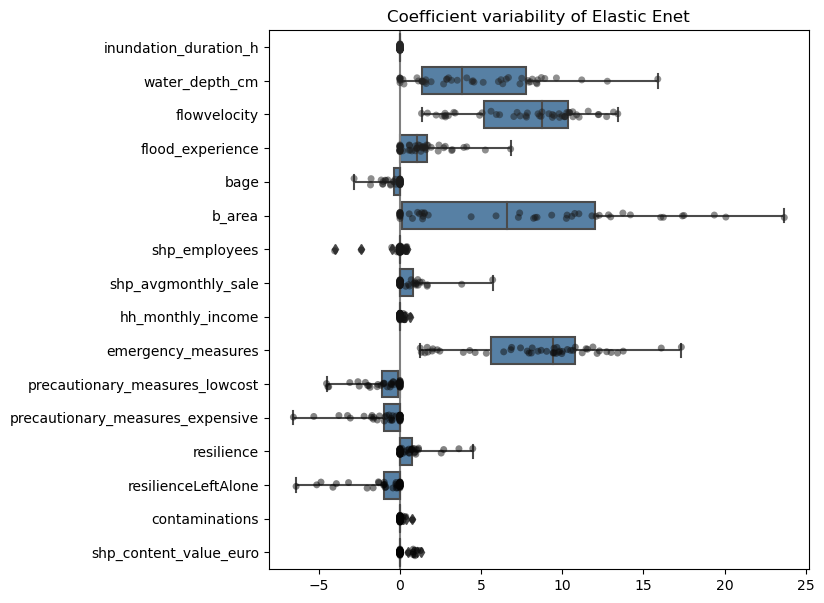

In [ ]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="steelblue", saturation=0.7, whis=100)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability of Elastic Enet")
plt.subplots_adjust(left=0.3)



--> coefficients of flowvelocity and purchase pumping equipment varying a lot depneding of the fold
--> registered capital, average monthly sale, monthly income coefficients are varying a lot depending of the fold.

**The regularization reduces the influence of correlated variables on the model because the weight is shared between the two predictive variables, so neither alone would have strong weights.**

### Feature Importances 


#### prepare Feature Importances 
Have the same feature importance method across all applied ML models
Weight Importances by model performance on outer loop (mean MAE)

In [21]:
s = df_feature_importances

In [22]:
## Overall FI ranking (procedure similar to Rözer et al 2019; Brill 2022)

## scale importance scores to  same units (non important feautres were removed before)
df_feature_importances = pd.DataFrame(
    MinMaxScaler(feature_range=(0,10)).fit_transform(df_feature_importances), 
    index=df_feature_importances.index,
    columns=df_feature_importances.columns
)
print(df_feature_importances.head(2))


                       crf_importances  xgb_importances  en_importances
inundation_duration_h         1.162670         5.334643        0.000000
water_depth_cm                9.777883         5.526565        2.615515


In [23]:
## weight FI scores based on performance 
## weigth importances from better performed models more

crf_scores = models_scores[f"crf"] ["MAE"] # outer MAE of CRF

for m in ["xgb", "en"]: 
    df_feature_importances[f"{m}_importances_weighted"] =  df_feature_importances[f"{m}_importances"] / np.abs(models_scores[m]["test_MAE"].mean())
df_feature_importances["crf_importances_weighted"]  = df_feature_importances["crf_importances"] / crf_scores    # weigth better models more

df_feature_importances.head(2)


KeyError: 'MAE'

In [24]:
## overall FI scores
df_feature_importances["mean_all_importances_weighted"] = df_feature_importances[["xgb_importances_weighted","en_importances_weighted", "crf_importances_weighted"]].mean(axis=1)
## drop feautres which are unimportant
df_feature_importances = df_feature_importances.loc[df_feature_importances["mean_all_importances_weighted"] > 0.000000, : ]
print(
    "10 most important features across all models (weighted on mean MAE scores):\n" ,
    #df_feature_importances.overall_importances.sort_values(ascending=False).head()
)
df_feature_importances.sort_values("mean_all_importances_weighted", ascending=False)[:10]#.describe()


KeyError: "None of [Index(['xgb_importances_weighted', 'en_importances_weighted',\n       'crf_importances_weighted'],\n      dtype='object')] are in the [columns]"

In [ ]:
## save to disk
df_feature_importances.to_excel(
    f"../../input_survey_data/selected_predictors/feature_importances_allmodels_{target.split('_')[1]}.xlsx", 
    index=False
)


####  Plot Feature importances

In [ ]:
## the best model has the highest weighted feature importance value
# df_feature_importances.describe()

In [ ]:
#df_feature_importances = df_feature_importances_logreg
df_feature_importances["sum_all_importances_weighted"] = df_feature_importances.fillna(0)["xgb_importances_weighted"] + df_feature_importances.fillna(0)["en_importances_weighted"] + df_feature_importances.fillna(0)["crf_importances_weighted"]
df_feature_importances = df_feature_importances.sort_values("sum_all_importances_weighted", ascending=True)
df_feature_importances.head(5)

,en_importances,crf_importances,xgb_importances,xgb_importances_weighted,en_importances_weighted,crf_importances_weighted,mean_all_importances_weighted,sum_all_importances_weighted
contaminations,0.0,0.066215,0.000000,0.000000,0.0,0.003708,0.001236,0.003708
hh_monthly_income,0.0,0.000000,1.396474,0.085998,0.0,0.000000,0.028666,0.085998
precautionary_measures_lowcost,0.0,0.983365,0.821973,0.050619,0.0,0.055073,0.035231,0.105692
precautionary_measures_expensive,0.0,2.574812,0.437052,0.026914,0.0,0.144202,0.057039,0.171116
resilienceLeftAlone,0.0,0.432256,2.542640,0.156581,0.0,0.024208,0.060263,0.180789


In [ ]:
df_feature_importances#[["xgb_importances_weighted", "crf_importances_weighted", "en_importances_weighted"]]

,en_importances,crf_importances,xgb_importances,xgb_importances_weighted,en_importances_weighted,crf_importances_weighted,mean_all_importances_weighted,sum_all_importances_weighted
contaminations,0.000000,0.066215,0.000000,0.000000,0.000000,0.003708,0.001236,0.003708
hh_monthly_income,0.000000,0.000000,1.396474,0.085998,0.000000,0.000000,0.028666,0.085998
precautionary_measures_lowcost,0.000000,0.983365,0.821973,0.050619,0.000000,0.055073,0.035231,0.105692
precautionary_measures_expensive,0.000000,2.574812,0.437052,0.026914,0.000000,0.144202,0.057039,0.171116
resilienceLeftAlone,0.000000,0.432256,2.542640,0.156581,0.000000,0.024208,0.060263,0.180789
shp_avgmonthly_sale,0.000000,2.270459,1.140179,0.070214,0.000000,0.127157,0.065790,0.197371
shp_employees,0.000000,2.678688,1.709488,0.105274,0.000000,0.150019,0.085098,0.255293
flood_experience,0.385749,2.365162,1.953089,0.120275,0.020053,0.132460,0.090930,0.272789
b_area,0.321579,1.846687,2.772674,0.170747,0.016717,0.103423,0.096962,0.290887
inundation_duration_h,0.000000,0.947013,4.107176,0.252928,0.000000,0.053037,0.101988,0.305965


<Figure size 3000x2200 with 0 Axes>

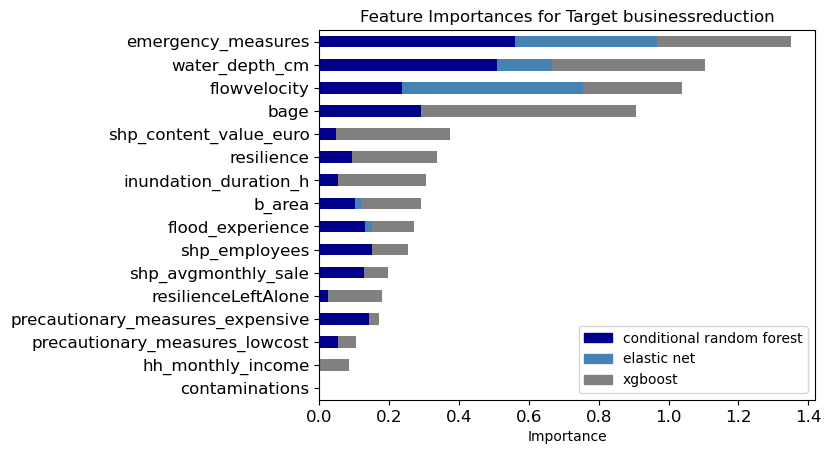

In [ ]:
### drop features which dont reduce the loss
df_feature_importances_plot = df_feature_importances#.loc[df_feature_importances.sum_all_importances_weighted > 0.01, : ] 
#df_feature_importances_plot = df_feature_importances.loc[df_feature_importances.sum_all_importances_weighted > 2, : ] 
#df_feature_importances_plot = df_feature_importances.sort_values("mean_all_importances_weighted", ascending=True)

plt.figure(figsize=(30, 22))
#df_feature_importances.plot.barh(
df_feature_importances_plot[["crf_importances_weighted", "en_importances_weighted", "xgb_importances_weighted",]].plot.barh(
    stacked=True, 
    #color="darkblue",
    color={"crf_importances_weighted":"darkblue", "en_importances_weighted":"steelblue", "xgb_importances_weighted":"grey"},
    width=0.5,
    # #errorbar="sd",
    # errorbar=("pi", 50), 
    # capsize=.1, errcolor=".5",
    # linewidth=3,
    )
plt.xlabel("Importance")
plt.ylabel("")
plt.title(f"Feature Importances for {target.replace('_',' ')}")


top_bar = mpatches.Patch(color="darkblue", label="conditional random forest")
middle_bar = mpatches.Patch(color="steelblue", label="elastic net")
bottom_bar = mpatches.Patch(color="grey", label="xgboost")
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.legend(handles=[top_bar, middle_bar, bottom_bar], loc="lower right")
#plt.tight_layout()
#plt.grid(None)

plt.show()

#sns.despine(left=True, bottom=True)
## save importance scores and figure
#filepath = f'./models_evaluation/best_xgb_importance_scores_{target}_{pipe_name}'
#if not glob(filepath):
#    df_importance.to_csv(filename, index = False)
#plt.savefig(f'../../figures/best_en_feature_importance_{target}_{pipe_name}.png', bbox_inches='tight')



### Save final feature space 
The final selection of features is used later for the non-parametric Bayesian Network

In [ ]:
## sort features by their overall importance (weighted sum across across all features) , first column contains the target
final_feature_names = df_feature_importances.sort_values("sum_all_importances_weighted", ascending=False).index##[:10]

## drop records with missing target values
print(f"Dropping {df_candidates[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
df_candidates = df_candidates[ ~df_candidates[f"{target}"].isna()]
print(f"Keeping {df_candidates.shape[0]} records and {df_candidates.shape[1]} features")

fs.save_selected_features(
    df_candidates, 
    pd.DataFrame(df_candidates, columns=[target]), 
    final_feature_names,
    filename=f"../../input_survey_data/final_data_{target.split('_',1)[-1].rsplit('_',1)[0]}_tueb.xlsx"
)


Dropping 36 records from entire dataset due that these values are nan in target variable
Keeping 357 records and 17 features
total features: 17
dropped features: 1
selected 16 features: 
['emergency_measures', 'water_depth_cm', 'flowvelocity', 'bage', 'shp_content_value_euro', 'resilience', 'inundation_duration_h', 'b_area', 'flood_experience', 'shp_employees', 'shp_avgmonthly_sale', 'resilienceLeftAlone', 'precautionary_measures_expensive', 'precautionary_measures_lowcost', 'hh_monthly_income', 'contaminations']

Saving model to disk: ../../../input_survey_data/final_data_businessreduction_tueb.xlsx


### Partial dependence
PDP shows the marginal effect that one or two features have on the predicted outcome. It shows whether the relationship between the target and a feature is linear, monotonic, or more complex ,as well as the direction of the relationship (see also Coefficients for linear regression tasks). It is introduced by J. H. Friedman and has been widely applied in machine learning modeling.

In [15]:
# # fit_params={"model__early_stopping_rounds":10, 
# #             "model__eval_metric" : "mae", 
# #             "model__eval_test_size": 50,
# #             }
# tst_final_model = RandomizedSearchCV( # GridSearchCV( 
#             estimator=pipe,
#             #param_grid=param_space,
#             param_distributions=param_space,
#             cv=cv, 
#             scoring="neg_mean_absolute_error",
#             refit=True,   
#             random_state=seed,
#         )

# df_candidates_t_nonan = df_Xy.dropna()
# tst_final_model.fit(
#     df_candidates_t_nonan.drop(target, axis=1), 
#     df_candidates_t_nonan[target],
#     #**fit_params
# )
# final_models_trained["xgb_tst"] = tst_final_model.best_estimator_

In [16]:
# ## TODO test with percenticels without nans


In [17]:
# m = model_evaluation()
# t = m.decorator_func(model=final_models_trained["crf"], Xy=eval_sets["crf"], y_name=target, feature_name="flowvelocity", scale=True) (get_partial_dependence)() #model=final_models_trained["crf"], Xy=eval_set_list["en"]["en"], y_name=target, feature_name="flowvelocity", scale=False)
# t
## Q:
## how to simplyfy call of decorated function-> eg. second part of argumets for get_partial_dependence() is useless
## why call fun(*, **) inside wrapper(), or purpoe of @decorator(func)
## how to store multiple decorators: in the classes in which they decorate a func or in a seperate class eg. for only R-decorators

In [52]:
from sklearn.inspection import partial_dependence
class model_evaluation(object):
    """
    
    """    
    ## decorator for R model
    def decorator_func(self, model , Xy, y_name, feature_name, scale=True):
        """
        Decorator to get partial dependence instead of python-sklearn-model from R-party-model
        """
        def r_get_partial_dependence(func):
            def wrapper(*args, **kwargs):
    
                X = Xy.dropna().drop(y_name, axis=1)
        
                # # scaled feature distributions in pd plots across models
                # if scale:
                #     X = pd.DataFrame(
                #         MinMaxScaler().fit_transform(X),
                #         columns=X.columns
                #     )
                # partial_dep = me.r_partial_dependence(
                #     model, 
                #     Xy,
                #     feature_name
                #     )
                # Xy = pd.concat([Xy[y_name], X], axis=1)
                robjects.r('''
                    r_partial_dependence <- function(model, df, predictor_name, verbose=FALSE) {
                        pdp::partial(model, train=df, pred.var=predictor_name, type="regression", plot=FALSE )  
                    }
                ''') #  , plot=FALSE --> to get pdp values
                r_partial_dependence = robjects.globalenv['r_partial_dependence'] 
                
                partial_dep = r_partial_dependence(model, Xy, feature_name)
                #return func(*args, **kwargs)
                return fs.r_dataframe_to_pandas(partial_dep)
            
            return wrapper
        return r_get_partial_dependence


    #@decorator(model=final_models_trained["crf"], Xy=eval_set_list["crf"]["crf"], target_name=target, feature_name="flowvelocity", scale=True) 
    ## not using decorator @
    def get_partial_dependence(self, **kwargs):
        model = kwargs["model"]
        Xy = kwargs["Xy"]
        y_name = kwargs["y_name"]
        feature_name = kwargs["feature_name"]
        scale = kwargs["scale"]

        X = Xy.dropna().drop(y_name, axis=1)

        # scale feature distributions in pd plots across models
        if scale:
            X =  pd.DataFrame(
                MinMaxScaler().fit_transform(X),
                columns=X.columns
            )
        partial_dep = partial_dependence(   
            estimator=model,
            X=X,
            features=feature_name,
            grid_resolution=X.shape[0],
            kind="average", 
            #**kwargs,
        )
        partial_dep_df = pd.DataFrame({
            feature_name : partial_dep.grid_values[0],
                "yhat": partial_dep.average[0]
            }
        )
        return partial_dep_df


In [17]:
# eval_sets["crf"]

In [54]:
## EN, XGB get partial dependences

## store partial dependences for each model
pdp_features = {a : {} for a in ["en", "xgb", "crf"]}

ee = model_evaluation()


for model_name in ["en", "crf", "xgb"]:

    Xy_pdp = eval_sets[model_name].dropna() #  solve bug on sklearn.partial_dependece() which can not deal with NAN values
    X_pdp, y_pdp = Xy_pdp[Xy_pdp.columns.drop(target)], Xy_pdp[target]
    X_pdp = pd.DataFrame(
        MinMaxScaler().fit_transform(X_pdp), # for same scaled pd plots across models
        columns=X.columns
        )
    Xy_pdp = pd.concat([y_pdp, X_pdp], axis=1)



    for predictor_name in X.columns.to_list(): 
        features_info =  {
            #"percentiles" : (0.05, .95) # causes NAN for some variables for XGB if (0, 1)
            "model" : final_models_trained[model_name], 
            "Xy" : Xy_pdp, 
            "y_name" : target, 
            "feature_name" : predictor_name, 
            "scale"  : True
        }         

        if model_name != "crf":   
            print(predictor_name)
            partial_dep = ee.get_partial_dependence(
                model=final_models_trained[model_name], 
                Xy=Xy_pdp, 
                y_name=target, 
                feature_name=predictor_name, 
                scale=True,
                #**features_info
            )
            # X = Xy_pdp.dropna().drop(target, axis=1)
            # model=final_models_trained[model_name]
            # # scale feature distributions in pd plots across models
            # scale = True
            # if scale:
            #     X =  pd.DataFrame(
            #         MinMaxScaler().fit_transform(X),
            #         columns=X.columns
            #     )
            # partial_dep = partial_dependence(   
            #     model,
            #     X=X,
            #     features=predictor_name,
            #     grid_resolution=X.shape[0],
            #     kind="average", 
            #     #**features_info,
            # )

        else:  # process R models
            print("crf: ", predictor_name)
            partial_dep = ee.decorator_func(       #  change function only temporally        
                **features_info
            ) (ee.get_partial_dependence)()

        pdp_features[model_name][predictor_name] = partial_dep



inundation_duration_h
water_depth_cm
flowvelocity
flood_experience
bage
b_area
shp_employees
shp_avgmonthly_sale
hh_monthly_income
emergency_measures
precautionary_measures_lowcost
precautionary_measures_expensive
resilience
resilienceLeftAlone
contaminations
shp_content_value_euro
crf:  inundation_duration_h
crf:  water_depth_cm


In [23]:
pdp_features["xgb"]

{}

In [1]:
plt.figure(figsize=(10,25))
#plt.subplots_adjust(hspace=0.9)
#plt.suptitle(f"Partial Dependences for {target}", fontsize=18, y=0.95)


most_important_features = df_feature_importances_plot.sort_values("sum_all_importances_weighted", ascending=False).index



idx = 0
categorical = [] # ["flowvelocity"]
ncols = 3
nrows = len(most_important_features[:10])

## create PDP for all three models
for feature in most_important_features[:10]:
    for model_name, color, idx_col in zip(["crf", "en", "xgb"], ["darkblue", "steelblue","grey"], [0, 1, 2]):
        
        # idx position of subplot
        ax = plt.subplot(nrows, ncols, idx + 1 + idx_col)
        feature_info = {"color" : color, "ax" : ax} 

        # plot
        df_pd_feature = pdp_features[model_name][feature]  
        p = f.plot_partial_dependence(
            df_pd_feature, feature_name=feature, partial_dependence_name="yhat", 
            categorical=[],
            **feature_info
            )
        p
        sns.rugplot(df_pd_feature, x=feature, y="yhat", heiht=-.02)

    idx = idx + 3

#plt.subplots_adjust(top=0.2)
#plt.savefig("test_pdp.jpg", bbox_inches="tight")


NameError: name 'plt' is not defined

- for large buidlings the en model predicts higher losses
- higher losses are also linked in the model with slightly less flood experience and higher flowvelocity ,
- model predicts for shops with very low registered capital less losses
- implmenting resistant building material after the flood (nb=4) is linked in the model with higher losses

### Empirical median ~ predicted median

And further statitics compared to their empirical counterpart.
-  mean /variance / std  compared to empirical distribution

In [ ]:
#model.predict()


In [ ]:
print("Testing models for : ", target)
e.empirical_vs_predicted(
    X, y,
    models_list = [models_trained["crf"], models_trained["xgb"]]#, models_trained["trained_en"]] 
    #models_trained#[f"trained_{model_name}_cv"]
    #models_list=[model, model_log, model_quantile, model_boxcox, model_sqrt]    
)

## TODO fix y empirical
# ## TODO idea: make a median/mean etc of best model as boxplots 8one (3 models for each target)


Testing models for :  Target_relative_contentloss_euro


AttributeError: 'ListVector' object has no attribute 'predict'

In [ ]:
# print(target)
# print(X.shape)

# df_importance

In [ ]:
print("median entire ds")
print(np.median(y))
#print(np.median(model.predict(X)))
y_pred = model
print(np.median([outer_y_pred[{model_name}]]))

print("mean entire ds")
print(np.mean(y))
#print(np.mean(model.predict(X)))
y_pred = model
print(np.mean([outer_y_pred[{model_name}]]))


median entire ds
0.01000119482099409
0.04939702
mean entire ds
0.056081992063753514
0.060931973


In [ ]:
##  MAE: + in target unit +  less likely to be affected by extreme values.
## MAPE: r (MAPE) quantifies the average absolute difference between 
## the anticipated and observed values of the target variable as a percentage of the observed value. 
## The method works well for assessing models where the target variable spans a broad range of scales


In [ ]:


##pipelines = ["pipe_bag_en"]#, 
pipelines = ["pipe_en" ]#
pipe_name = pipelines[0]

#model_eval = pickle.load(open(f"./models_trained/best_elasticnet_{target}_{pipe_name}.sav", 'rb'))
#elastic_net_eval.get_params()



### Plot prediction error 

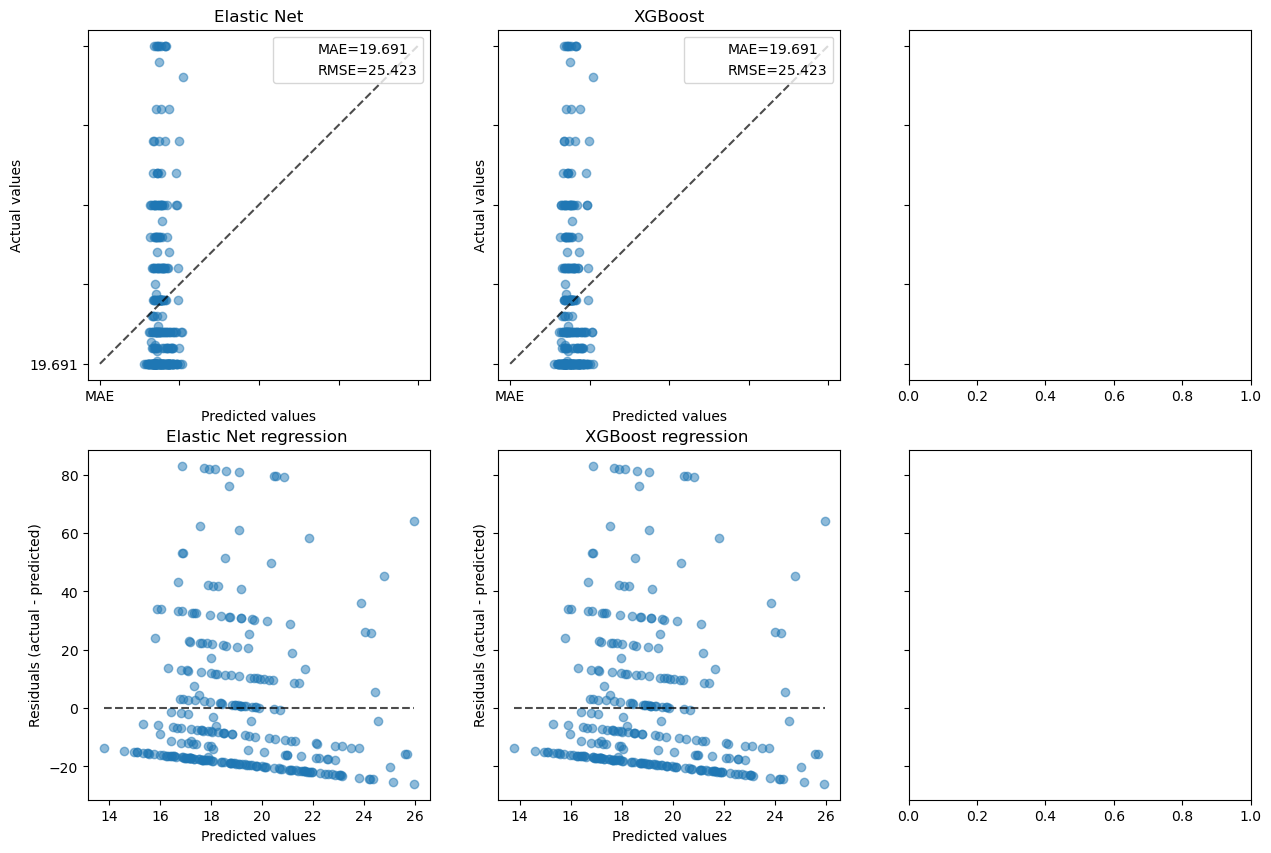

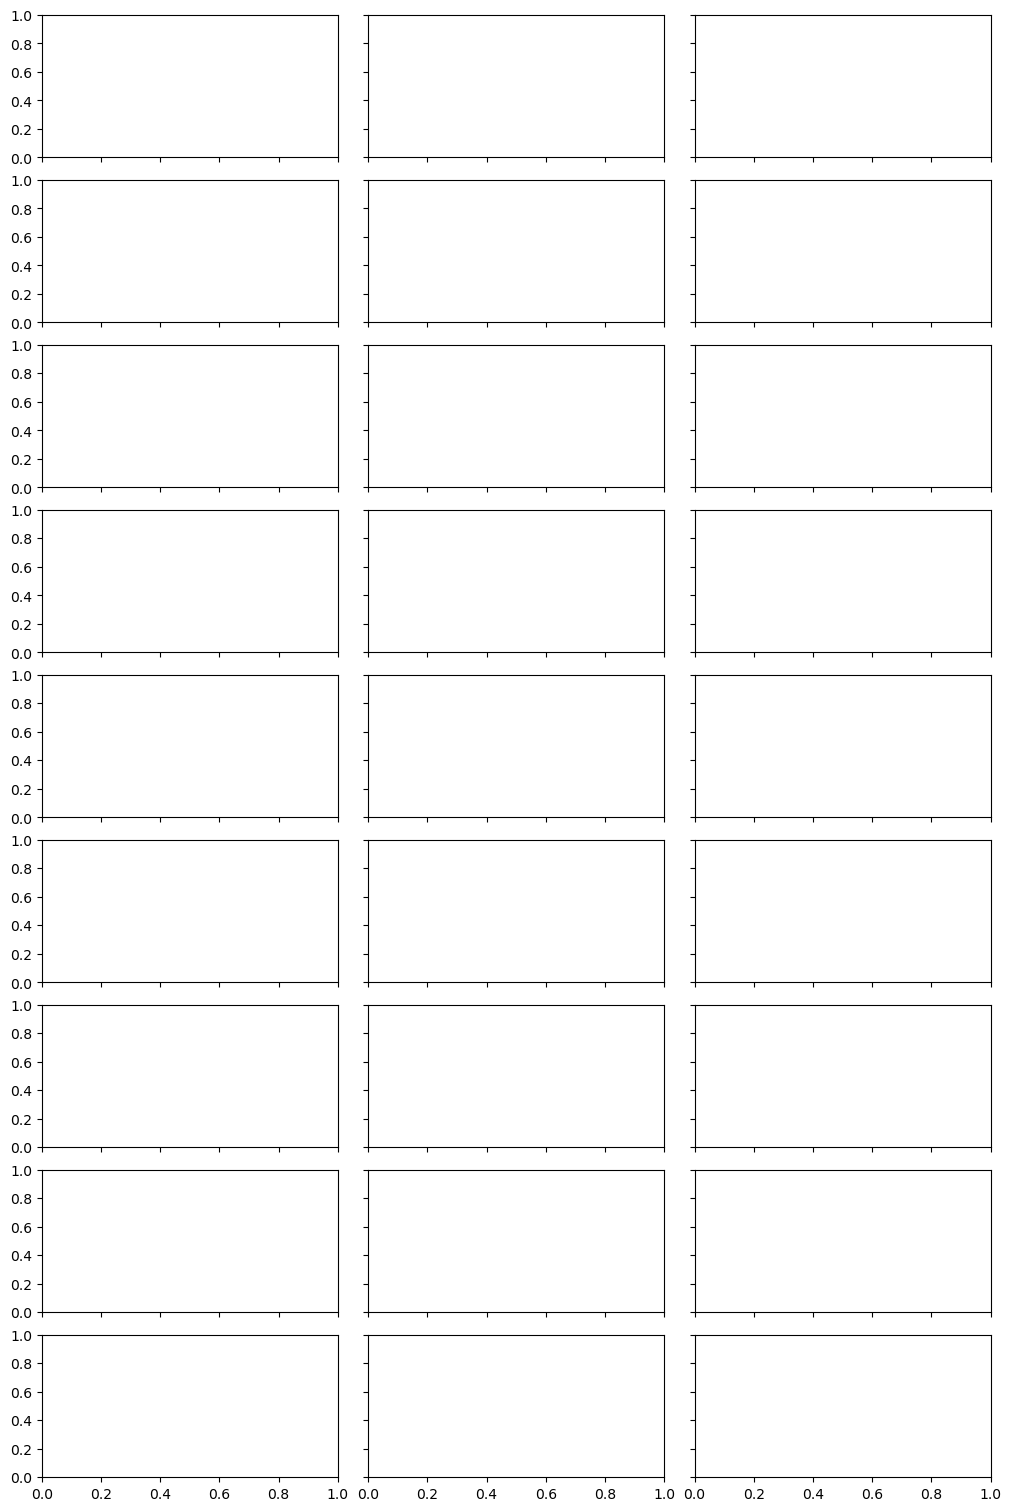

In [ ]:
f.plot_residuals(residuals=predicted_values, model_names_abbreviation=["en", "xgb", "crf"],  model_names_plot=["Elastic Net", "XGBoost", "Conditional Random Forest"])
